In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
import sys
import random
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
import pickle
import sys
import networkx as nx
from definitions import get_node_color, get_node_id
sys.path.append("./..")
from bi_graph import BiGraph
from population_graph import Population_Graph
from utils import PROJECT_ROOT

# Fit BiGraph model

In [2]:
# read single cell data and clinical data
cells = pd.read_csv(os.path.join(PROJECT_ROOT, "Datasets/Danenberg_et_al/cells.csv"))
clinical = pd.read_csv(
    os.path.join(PROJECT_ROOT, "Datasets/Danenberg_et_al/clinical.csv")
)
print("Initially,")
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove images without invasive tumor
print("\nRemove images without invasive tumor,")
cells = cells.loc[cells.isTumour == 1]
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove patients with no clinical data
print("\nRemove patients with no clinical data,")
cells = cells.loc[cells["metabric_id"].isin(clinical["metabric_id"])]
print(
    "{} patients ({} images) with cell data and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)
# remove images with less than 500 cells
print("\nRemove images with less than 500 cells")
cells_per_image = cells.groupby("ImageNumber").size()
cells = cells.loc[
    cells["ImageNumber"].isin(cells_per_image[cells_per_image > 500].index)
]
clinical = clinical.loc[clinical["metabric_id"].isin(cells["metabric_id"].unique())]
print(
    "{} patients ({} images) with more than 500 cells and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)

random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical["Subset_id"] = Subset_id
cells_discovery = cells.loc[
    cells["metabric_id"].isin(clinical.loc[clinical["Subset_id"] == 1, "metabric_id"])
]
cells_validation = cells.loc[
    cells["metabric_id"].isin(clinical.loc[clinical["Subset_id"] == 2, "metabric_id"])
]
print("\nAfter splitting into discovery and validation sets,")
print(
    "{} patients ({} images) with more than 500 cells and clinical data in the discovery set, ".format(
        len(cells_discovery["metabric_id"].unique()),
        len(cells_discovery["ImageNumber"].unique()),
    )
)
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells_discovery['cellTypeID'] = cells_discovery['meta_description'].map(get_node_id('Danenberg', 'CellType') )
cells_discovery = cells_discovery.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

cells_validation['cellTypeID'] = cells_validation['meta_description'].map(get_node_id('Danenberg', 'CellType') )
cells_validation = cells_validation.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )
bigraph_ = BiGraph(k_patient_clustering = 30)
Population_graph, Patient_subgroups, _ = bigraph_.fit_transform(
    cells_discovery
)


Initially,
718 patients (794 images) with cell data, 2604 patients with clinical data, 

Remove images without invasive tumor,
693 patients (749 images) with cell data, 2604 patients with clinical data, 

Remove patients with no clinical data,
683 patients (737 images) with cell data and clinical data, 

Remove images with less than 500 cells
579 patients (621 images) with more than 500 cells and clinical data, 

After splitting into discovery and validation sets,
379 patients (404 images) with more than 500 cells and clinical data in the discovery set, 
There is a soft wl subtree kernel fitted before. We will load it directly.
If you want to re-calculate the similarity matrix, please delete the file '3_fit_wl_subtree_kernel.py'.


/tmp/ipykernel_3185568/4194879106.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_discovery['cellTypeID'] = cells_discovery['meta_description'].map(get_node_id('Danenberg', 'CellType') )
/tmp/ipykernel_3185568/4194879106.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_validation['cellTypeID'] = cells_validation['meta_description'].map(get_node_id('Danenberg', 'CellType') )


An overview of the input cellular graphs is as follows: 
	 379 unique patients.
	 32 unique cell types.
	 670335 total cells, 1768.69 cells per patient.
An overview of the identified patterns is as follows: 
	 66 discovered patterns.
Start generating population graph.
Initialized Population_Graph, k_clustering =  30 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Population graph generated.
Start detecting patient subgroups.
Patient subgroups detected.
There are 7 patient subgroups, 0 ungrouped patients
Start finding characteristic patterns for each patient subgroup.
Characteristic patterns found.


In [3]:
Patient_ids = bigraph_.Patient_ids
cph = CoxPHFitter()
lengths = [
    clinical.loc[
        clinical["metabric_id"] == i, "Disease-specific Survival (Months)"
    ].values[0]
    for i in Patient_ids
]
statuses = [
    (
        0
        if clinical.loc[
            clinical["metabric_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        == "0:LIVING"
        else 1
    )
    for i in Patient_ids
]
for i in range(len(Patient_subgroups)):
    subgroup = Patient_subgroups[i]
    patient_ids = subgroup['patient_ids']
    DF = pd.DataFrame(
        {
            "length": lengths,
            "status": statuses,
            "community": np.isin(Patient_ids, patient_ids),
        }
    )
    cph.fit(
        DF,
        duration_col="length",
        event_col="status",
        show_progress=False,
    )
    Patient_subgroups[i]["hr"] = cph.hazard_ratios_["community"]
    Patient_subgroups[i]["p"] = cph.summary["p"]["community"]
    Patient_subgroups[i]["hr_lower"] = np.exp(
                cph.confidence_intervals_["95% lower-bound"]["community"]
            )
    Patient_subgroups[i]["hr_upper"] = np.exp(
                cph.confidence_intervals_["95% upper-bound"]["community"]
            )

Patient_subgroups = sorted(Patient_subgroups, key=lambda x: x["hr"], reverse=True)
for i in range(len(Patient_subgroups)):
    Patient_subgroups[i]['subgroup_id'] = 'S'+str(i+1)
    print(
        "Patient subgroup S{}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            i + 1, len(Patient_subgroups[i]['patient_ids']), Patient_subgroups[i]["hr"], Patient_subgroups[i]["hr_lower"], Patient_subgroups[i]["hr_upper"], Patient_subgroups[i]["p"]
        )
    )

Patient subgroup S1: N = 26, HR = 2.43 (1.43-4.11), p = 9.53e-04
Patient subgroup S2: N = 48, HR = 1.67 (1.06-2.65), p = 2.84e-02
Patient subgroup S3: N = 23, HR = 1.20 (0.59-2.45), p = 6.19e-01
Patient subgroup S4: N = 73, HR = 1.15 (0.76-1.75), p = 5.15e-01
Patient subgroup S5: N = 61, HR = 0.97 (0.61-1.53), p = 8.87e-01
Patient subgroup S6: N = 51, HR = 0.62 (0.33-1.14), p = 1.24e-01
Patient subgroup S7: N = 97, HR = 0.51 (0.32-0.82), p = 5.38e-03


# Load Clinical Data

In [4]:
clinical = pd.read_csv(
    os.path.join(PROJECT_ROOT, "Datasets/Danenberg_et_al/clinical.csv")
)
Patient_ids = bigraph_.Patient_ids
ER_status  = [clinical.loc[clinical.metabric_id == i, 'ER Status'].values[0] for i in Patient_ids]
PR_status  = [clinical.loc[clinical.metabric_id == i, 'PR Status'].values[0] for i in Patient_ids]
HER2_status  = [clinical.loc[clinical.metabric_id == i, 'HER2 Status'].values[0] for i in Patient_ids]
Clinical_subtype_id = np.zeros(len(Patient_ids), dtype=object)
Clinical_subtype_id[:] = 'Unknown'
for i in range(len(ER_status)):
    er = ER_status[i]
    pr = PR_status[i]
    her2 = HER2_status[i]
    if  her2 == "Positive":
        Clinical_subtype_id[i] = 'HER2+' # Her2+
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        Clinical_subtype_id[i] = 'HR+/HER2-' # HR+/HER2-
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        Clinical_subtype_id[i] = 'TNBC' # TNBC
print(
    "{} patients in total, {} Unkonw, {} HER2+, {} HR+/HER2-, {} TNBC".format(
        len(Clinical_subtype_id),
              np.sum(Clinical_subtype_id == 'Unknown'),
        np.sum(Clinical_subtype_id == 'HER2+'),
        np.sum(Clinical_subtype_id == 'HR+/HER2-'),
        np.sum(Clinical_subtype_id == 'TNBC'),
  

    )
)

379 patients in total, 54 Unkonw, 32 HER2+, 243 HR+/HER2-, 50 TNBC


# Comparaion of inter-patient similarities (Table 1)

In [6]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
Similarity_matrix = bigraph_.Similarity_matrix
print("The mutual similarity of the population graph is {:.2f}".format( caculate_mutual_similarity(Similarity_matrix)))

The mutual similarity of the population graph is 0.18


## Clincial Subtypes

In [7]:

Gram_matrix_ = Similarity_matrix[np.array(np.where(Clinical_subtype_id == 1)[0].tolist()), :][:, np.array(np.where(Clinical_subtype_id == 1)[0].tolist())]
print("{} HER2+ patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Clinical_subtype_id == 2)[0].tolist()), :][:, np.array(np.where(Clinical_subtype_id == 2)[0].tolist())]
print("{} HR+/HER2- patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Clinical_subtype_id == 3)[0].tolist()), :][:, np.array(np.where(Clinical_subtype_id == 3)[0].tolist())]
print("{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))


IndexError: arrays used as indices must be of integer (or boolean) type

## BiGraph

In [8]:
Subgroup_ids = np.zeros(len(Patient_ids), dtype=object)
Subgroup_ids[:] = "Unclassified"
for i in range(len(Patient_subgroups)):
    subgroup = Patient_subgroups[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    Subgroup_ids[np.isin(Patient_ids, patient_ids)] = subgroup_id

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S1")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S1")[0].tolist())]
print("{} patients in S1, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S2")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S2")[0].tolist())]
print("{} patients in S2, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S3")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S3")[0].tolist())]
print("{} patients in S3, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S4")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S4")[0].tolist())]
print("{} patients in S4, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S5")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S5")[0].tolist())]
print("{} patients in S5, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S6")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S6")[0].tolist())]
print("{} patients in S6, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

Gram_matrix_ = Similarity_matrix[np.array(np.where(Subgroup_ids == "S7")[0].tolist()), :][:, np.array(np.where(Subgroup_ids == "S7")[0].tolist())]
print("{} patients in S7, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))

26 patients in S1, averaged Intra-group similarity is 0.75 
48 patients in S2, averaged Intra-group similarity is 0.26 
23 patients in S3, averaged Intra-group similarity is 0.73 
73 patients in S4, averaged Intra-group similarity is 0.45 
61 patients in S5, averaged Intra-group similarity is 0.32 
51 patients in S6, averaged Intra-group similarity is 0.61 
97 patients in S7, averaged Intra-group similarity is 0.37 


# Correlation and Alignment (Fig.7)

### Population Graph painted with clinical subtype (Fig.7.a)

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1019: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


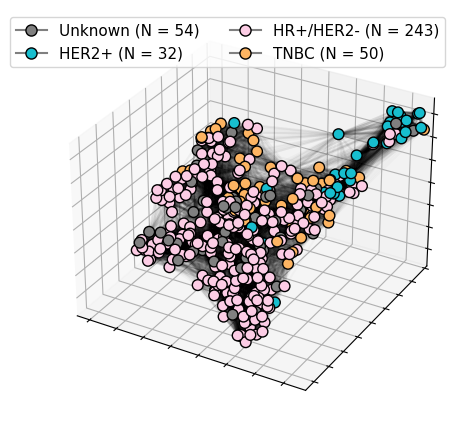

In [32]:
color_palette = {
    "Unknown": "grey",
    "HER2+": sns.color_palette("tab10")[9],
    'HR+/HER2-': sns.color_palette("Set3")[7],
    'TNBC': sns.color_palette("Set3")[5],
}
# For visualization purpose, we make nodes distant from each other
Population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, Patient_ids
)  # generate population graph
pos = nx.spring_layout(
    Population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(Population_graph)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in Population_graph.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[i] for i in Clinical_subtype_id],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(Population_graph.edges())
edge_alpha = [
    (
        0.2 * Population_graph[u][v]["weight"]
        if Population_graph[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for clinical_subtype_id in ['Unknown', 'HER2+', 'HR+/HER2-', 'TNBC']:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette[clinical_subtype_id],
            label="{} (N = {})".format(
                clinical_subtype_id, np.sum(Clinical_subtype_id == clinical_subtype_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=11, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


## Spearmanr correlation (Fig.6.b)

Clinical Subtype: HER2+, Subgroup: S1, correlation_coefficient: 0.63, p_val: 1.83e-43
Clinical Subtype: HER2+, Subgroup: S7, correlation_coefficient: -0.16, p_val: 2.27e-03
Clinical Subtype: TNBC, Subgroup: S2, correlation_coefficient: 0.23, p_val: 8.36e-06
Clinical Subtype: TNBC, Subgroup: S4, correlation_coefficient: 0.21, p_val: 5.80e-05
Clinical Subtype: TNBC, Subgroup: S7, correlation_coefficient: -0.16, p_val: 2.15e-03
Clinical Subtype: HR+/HER2-, Subgroup: S1, correlation_coefficient: -0.28, p_val: 4.86e-08
Clinical Subtype: HR+/HER2-, Subgroup: S7, correlation_coefficient: 0.17, p_val: 6.66e-04


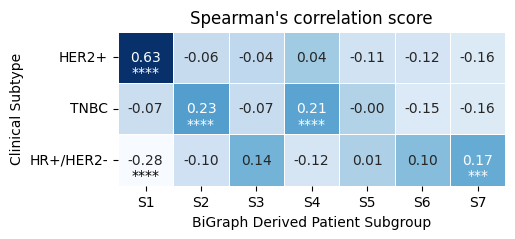

In [9]:
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
spearmanr_corr = np.zeros((3, 7))
P_value = np.zeros((3, 7))
for i in range(3):
    clinical_subtype = ["HER2+", "TNBC", "HR+/HER2-"][i]
    for j in range(7):
        subgroup_id = ["S1", "S2", "S3", "S4", "S5", "S6", "S7"][j]
        variable_1 = (np.array(Clinical_subtype_id) == clinical_subtype) 
        variable_2 = (np.array(Subgroup_ids) == subgroup_id)
        correlation_coefficient, p_value = spearmanr(variable_1, variable_2)
        spearmanr_corr[i,j] = correlation_coefficient
        P_value[i,j] = p_value
        if p_value < 0.05/(3*7):
            print(
                    "Clinical Subtype: {}, Subgroup: {}, correlation_coefficient: {:.2f}, p_val: {:.2e}".format(
                        clinical_subtype, subgroup_id, correlation_coefficient, p_value
                    )
                )

       
f, ax = plt.subplots(figsize=(5, 2))
sns.heatmap(spearmanr_corr, annot=True, fmt=".2f", cmap="Blues", cbar = False, linewidths=0.5, linecolor='white', ax=ax, vmax = 0.6)
ax.text(0 + 0.5, 0+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(0 + 0.5, 2+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'black'
                 )

ax.text(1 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(3 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )

ax.text(6 + 0.5, 2+0.8 , '***',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )


ax.set_xlabel("BiGraph Derived Patient Subgroup")
ax.set_ylabel("Clinical Subtype")
ax.set_xticklabels(["S1", "S2", "S3", "S4", "S5", "S6", "S7"] ,rotation=0)
ax.set_yticklabels(["HER2+", "TNBC", "HR+/HER2-"], rotation=0)
ax.set(title = "Spearman's correlation score")
plt.show()

# Enhancement of risk stratification